# Assessment 01

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

We created a separate notebook for the python-constraint approach because we wanted to give it a fair shot, but it turned out to take too long to solve the problem. Instead of discarding it completely, we kept that notebook as a record of the attempt and shifted focus to OR-Tools, which quickly proved to be much faster and more efficient. The second notebook became the main one, but the first still shows the process we went through and the limitations we encountered.

# Introduction

The project at hand focuses on solving an optimization problem using constraint programming to effectively schedule jobs with respect to their precedence relations, resource constraints, and time durations. The main objective is to minimize the makespan, which refers to the total time required to complete all jobs in a given horizon, while respecting job precedence and resource availability constraints.

This scheduling problem involves a set of jobs, each with specific durations and resource requirements. Additionally, jobs are interconnected by precedence relations, where some jobs must be completed before others can start. The challenge is to schedule these jobs in such a way that the project is completed in the shortest possible time, considering the limited availability of renewable resources.
will be using the Constraint satisfaction problem algo (CSP)

# Goal Formulation
The goal of this project is to minimize the makespan of a set of jobs while adhering to the constraints defined by job precedence, resource availability, and duration. Specifically, the system must find an optimal schedule for the jobs, ensuring that:

1. Job Precedence Constraints: Each job must be scheduled in a way that respects its predecessors (i.e., a job must be completed before its successor can start).
2. Resource Constraints: The usage of renewable resources (R1 and R2) must not exceed their respective availability at any point in time.
3. Minimizing Makespan: The final objective is to minimize the makespan, or the total time required to complete all jobs, while meeting the above constraints.

Possible Limitations:

-  Limited Resources: The problem is constrained by limited availability of renewable resources, and the optimization must respect this limitation. This may lead to longer schedules for certain configurations.
- Precedence Relations: Certain jobs depend on the completion of others, which can increase the difficulty of finding an optimal schedule.
- Horizon Constraint: The maximum allowable project duration (horizon) limits the search space, but must be considered in the formulation to prevent infeasible solutions.

Actions to be Taken:

- Model the problem using constraint programming to handle the complexity of precedence and resource constraints.
- Define variables for start times, end times, and intervals to represent job execution.
- Implement constraints to ensure job precedence and resource usage rules are followed.
- Optimize the schedule to minimize makespan while satisfying all constraints.


## Plan and Design an Appropriate Agent

- The environment consists of jobs with fixed durations, precedence relations, and resource demands (R1 and R2).
- Resource availability constrains how many jobs can run concurrently.
- The agent's actuators are the scheduling decisions: selecting start times for each job within the given horizon while ensuring no resource constraints are violated.
- The sensors of the agent are the job precedence, durations, and resource availability. These are used to guide the scheduling decisions and adjust dynamically to avoid conflicts.


## Characteristics of the Task Environment

- The data is fixed; job durations and resource requirements are known in advance.
- Jobs are scheduled in discrete time units.
- The problem does not change during execution; the job data and resources remain constant.
- Limited resource availability (R1 and R2) must be carefully managed to avoid overuse.


## Formulating the Problem as a Search Problem

- __Initial State__: All jobs are unscheduled, and no resources are used.
- __Goal State__: All jobs are scheduled with start times and precedence and resource constraints are satisfied.
- __State Representation__: A mapping of jobs to their start times and resource availability over time.
- __Actions__:
	- Schedule a job by assigning it a start time.
	- All predecessors are completed.
	- Required resources are available during the job's duration.
- __Objective Function__:
	- Minimize the project makespan:
		- Makespan = max( 𝑆𝑗 + duration𝑗 ) for all jobs 𝑗

# Implementation

In [2]:
%pip install ortools
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from time import time
import random
import logging

from ortools.sat.python import cp_model
import matplotlib.pyplot as plt

Define the file to use as dataSet

# Data structures definition for parsed data

In [4]:
class GeneralInformation:
    def __init__(
        self,
        projects,
        jobs,
        horizon,
        renewable_resources,
        nonrenewable_resources,
        doubly_constrained_resources,
    ):
        self.projects = projects
        self.jobs = jobs
        self.horizon = horizon
        self.resources = {
            "renewable": renewable_resources,
            "nonrenewable": nonrenewable_resources,
            "doubly_constrained": doubly_constrained_resources,
        }

In [5]:
class ProjectSummary:
    def __init__(
        self, project_number, jobs, release_date, due_date, tardiness_cost, mpm_time
    ):
        self.project_number = project_number
        self.jobs = jobs
        self.release_date = release_date
        self.due_date = due_date
        self.tardiness_cost = tardiness_cost
        self.mpm_time = mpm_time

In [6]:
class Job:
    def __init__(self, job_number, successors):
        self.job_number = job_number
        self.successors = successors

In [7]:
class DurationResource:
    def __init__(self, job_number, mode, duration, resources):
        self.job_number = job_number
        self.mode = mode
        self.duration = duration
        self.resources = resources

In [8]:
class ResourceAvailability:
    def __init__(self, resource_name, quantity):
        self.resource_name = resource_name
        self.quantity = quantity


In [9]:
class ProjectData:
    def __init__(self):
        self.general_info: GeneralInformation = None
        self.projects_summary: list[ProjectSummary] = []
        self.precedence_relations: list[Job] = []
        self.durations_resources: list[DurationResource] = []
        self.resource_availability: dict[str, ResourceAvailability] = {}

# Data parsing function

In [10]:
def parse_file(file) -> ProjectData:
    data = ProjectData()
    # Track the file section
    section = None

    for line in file:
        line = line.strip()

        # Skip ornament and invalid
        if line.startswith("**") or not line:
            continue

        if line.startswith("#"):
            # Match the file section
            match line:
                case "#General Information":
                    section = "general_info"
                    continue
                case "#Projects summary":
                    section = "projects_summary"
                    continue
                case "#Precedence relations":
                    section = "precedence_relations"
                    continue
                case "#Duration and resources":
                    section = "durations_resources"
                    continue
                case "#Resource availability":
                    section = "resource_availability"
                    continue

        match section:
            case "general_info":
                if "projects" in line:
                    data.general_info = GeneralInformation(
                        int(line.split(":")[1].strip()),
                        jobs=0,
                        horizon=0,
                        renewable_resources=0,
                        nonrenewable_resources=0,
                        doubly_constrained_resources=0,
                    )
                elif "jobs" in line:
                    data.general_info.jobs = int(line.split(":")[1].strip())
                elif "horizon" in line:
                    data.general_info.horizon = int(line.split(":")[1].strip())
                elif line.startswith("- renewable"):
                    data.general_info.resources["renewable"] = int(
                        line.split(":")[1].split()[0].strip()
                    )
                elif line.startswith("- nonrenewable"):
                    data.general_info.resources["nonrenewable"] = int(
                        line.split(":")[1].split()[0].strip()
                    )
                elif line.startswith("- doubly constrained"):
                    data.general_info.resources["doubly_constrained"] = int(
                        line.split(":")[1].split()[0].strip()
                    )

            case "projects_summary":
                # Skip header line
                if line.startswith("pronr."):
                    continue

                splits = line.split()
                if splits:
                    data.projects_summary.append(
                        ProjectSummary(
                            project_number=int(splits[0]),
                            jobs=int(splits[1]),
                            release_date=int(splits[2]),
                            due_date=int(splits[3]),
                            tardiness_cost=int(splits[4]),
                            mpm_time=int(splits[5]),
                        )
                    )

            case "precedence_relations":
                # Skip header line
                if line.startswith("#jobnr."):
                    continue

                splits = line.split()
                if splits:
                    data.precedence_relations.append(
                        Job(
                            job_number=int(splits[0]),
                            successors=list(map(int, splits[3:])),
                        )
                    )

            case "durations_resources":
                # Skip header line
                if line.startswith("#jobnr."):
                    continue

                splits = line.split()
                if splits:
                    resourcesData = {}
                    for i in range(len(splits) - 3):
                        resourcesData[f"R{i+1}"] = int(splits[i + 3])

                    data.durations_resources.append(
                        DurationResource(
                            job_number=int(splits[0]),
                            mode=int(splits[1]),
                            duration=int(splits[2]),
                            resources=resourcesData,
                        )
                    )

            case "resource_availability":
                # Skip header line
                if line.startswith("#resource"):
                    continue

                splits = line.split()
                if splits:
                    name = splits[0]

                    data.resource_availability[name] = ResourceAvailability(
                        resource_name=name, quantity=int(splits[1])
                    )

    return data


# Defining the model

## Variables, Domain, and Constraints for the Given Data

**Variables**:
- Start Times (for each job):
	- Integer variables representing the start time for each job. Each job's start time must be within the project horizon, from 0 to 20.
	Example: start_job_1, start_job_2, ..., start_job_8.

- End Times (for each job):
	- Integer variables representing the end time of each job. End time for each job is dependent on its start time and its duration.
	- Example: end_job_1, end_job_2, ..., end_job_8.

- Intervals (for each job):
	- Interval variables for each job, representing the time window in which a job is executed. The interval starts at the job's start time and ends at the job's end time.
	- Example: interval_job_1, interval_job_2, ..., interval_job_8.

- Makespan:
	- Integer variable that represents the total time taken to complete all jobs. This is defined as the maximum end time across all jobs.
	- Example: makespan.

---
**Domains**:

- Start Times Domain:
	-	Each start time variable for the jobs can take integer values from 0 to the project horizon (0 to 20).

- End Times Domain:
	- Each end time variable is constrained to be the sum of the corresponding start time and job duration.

- Interval Domain:
	-	Each interval variable must span from the job's start time to its end time, within the defined horizon.

- Makespan Domain:
	- The makespan variable can take values between 0 and 20, as the last job should finish within this time period.

---

**Constraints**:

1. Precedence Constraints:
	- For each job with successors, the end time of the current job must be less than or equal to the start time of the successor.
	- Example: If Job 1 precedes Job 2, then end_job_1 <= start_job_2.

2. Resource Constraints:
	- For each job, the demand for resources must be respected. This is enforced using a cumulative constraint.
	- Example: The total demand for resources at any given time must not exceed the available quantity. If two jobs require the same resource at the same time, their cumulative demand must not exceed the available resources.

3. Makespan Constraint:
	- The makespan variable must be greater than or equal to the end time of every job.
	- Example: makespan >= end_job_1, makespan >= end_job_2, ..., makespan >= end_job_8.

4. Duration and Resource Usage:
	- Each job has a fixed duration and a fixed demand for resources.
	- Example:
		- Job 1 requires 1 unit of R1 and 0 units of R2, with a duration of 2 time units.
		- Job 2 requires 0 units of R1 and 1 unit of R2, with a duration of 3 time units.

---

## How the Model Works
1. Job Representation:<br>
	Each job is represented by its start and end times, and an interval variable that encodes its duration.

2. Precedence Handling:<br>
	By iterating over data.precedence_relations, the model ensures that dependent jobs are scheduled in order.

3. Resource Handling:<br>
	The AddCumulative constraint enforces resource limits by summing demands of overlapping intervals.

4. Optimization:<br>
	The makespan variable aggregates the latest end time across all jobs, and minimizing it achieves the goal of reducing project duration.

In [11]:
def define_problem(data: ProjectData):
    model: cp_model.CpModel = cp_model.CpModel()
    horizon = data.general_info.horizon

    # Define variables for start times
    start_times = {}
    end_times = {}
    intervals = {}

    # Create variables and intervals for each job
    for job in data.precedence_relations:
        start_times[job.job_number] = model.NewIntVar(
            0, horizon, f"start_job_{job.job_number}"
        )
        duration = data.durations_resources[job.job_number - 1].duration
        end_times[job.job_number] = model.NewIntVar(
            0, horizon, f"end_job_{job.job_number}"
        )
        intervals[job.job_number] = model.NewIntervalVar(
            start_times[job.job_number],
            duration,
            end_times[job.job_number],
            f"interval_job_{job.job_number}",
        )
        model.Add(end_times[job.job_number] == start_times[job.job_number] + duration)

    # Add precedence constraints: Ensure each job finishes before its successor starts
    for job in data.precedence_relations:
        for successor in job.successors:
            model.Add(end_times[job.job_number] <= start_times[successor])

    # Add resource constraints: Ensure resource usage does not exceed availability
    for resource_name, resource_availability in data.resource_availability.items():
        tasks = []
        demands = []

        for duration_resource in data.durations_resources:
            demand = duration_resource.resources.get(resource_name, 0)
            if demand > 0:
                tasks.append(intervals[duration_resource.job_number])
                demands.append(demand)

        # Add cumulative constraint for this resource
        if tasks:
            model.AddCumulative(
                intervals=tasks,
                demands=demands,
                capacity=resource_availability.quantity,
            )

    # Define makespan variable and constrain it to be the maximum end time of all jobs
    makespan = model.NewIntVar(0, horizon, "makespan")
    for job in data.precedence_relations:
        model.Add(makespan >= end_times[job.job_number])

    # Set the objective to minimize makespan
    model.Minimize(makespan)

    return model, start_times

In [12]:
def extract_solution(solver, start_times, data: ProjectData):
    solution = {}
    for job in data.precedence_relations:
        job_number = job.job_number
        start_time = solver.Value(start_times[job_number])
        solution[f"job_{job_number}"] = start_time

    return solution

# Visualization

In [13]:
def random_color():
    return "#{:02x}{:02x}{:02x}".format(
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)
    )

# Data: start days and durations
# Prepare data for the Gantt chart
def draw_solution(solution, pData: ProjectData, file_path: str):
    job_names = list(solution.keys())
    start_day = list(solution.values())

    duration = [pData.durations_resources[int(job.split('_')[1]) - 1].duration for job in job_names]

    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(20, 12))

    # Generate a list of random colors
    colors = [random_color() for _ in job_names]

    # Horizontal bars
    ax.barh(job_names, duration, left=start_day, color=colors, edgecolor='black')

    # Add labels and grid
    ax.set_xlabel('Days')
    ax.set_ylabel('Jobs')
    ax.set_title(f'Job Schedule ({file_path})')
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Annotate each job bar with its duration
    for i, job in enumerate(job_names):
        ax.text(start_day[i] + duration[i] / 2, i, f'{duration[i]} days', ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [14]:
def plot_resource_usage(solution, project_data: ProjectData, file_path: str):
    horizon = max(value for  value in solution.values()) + 1
    # Initialize resource usage dynamically
    resource_usage = {
        resource: [0] * horizon for resource in project_data.resource_availability.keys()
    }


    # Compute resource usage
    for job_index, start_time in solution.items():
        job_number = int(job_index.split('_')[1]) - 1
        job_data = project_data.durations_resources[job_number]
        end_time = start_time + job_data.duration

        # Update resource usage for the duration of the job
        for t in range(start_time, end_time):
            if t < horizon:  # Stay within the horizon
                for resource, amount in job_data.resources.items():
                    resource_usage[resource][t] += amount

    # Plot the resource usage
    time_slots = range(horizon)
    plt.figure(figsize=(20, 12))

    for resource, usage in resource_usage.items():
        # Plot resource usage
        plt.plot(time_slots, usage, label=f"Resource {resource}", marker="o")

        # Plot resource availability as a horizontal line
        plt.axhline(
            y=project_data.resource_availability[resource].quantity,
            linestyle="--",
            label=f"{resource} Availability"
        )

    # Add labels, legend, and title
    plt.xlabel("Time (Days)")
    plt.ylabel("Resource Usage")
    plt.title(f"Resource Occupation Over Time ({file_path})")
    plt.legend()
    plt.grid()

    plt.xticks(range(horizon))  

    # Show the plot
    plt.show()

# Main

INFO:root: Solution found : 0.0155 seconds


INFO:root: Sollution: {'job_1': 0, 'job_2': 0, 'job_3': 0, 'job_4': 0, 'job_5': 1, 'job_6': 1, 'job_7': 1, 'job_8': 11, 'job_9': 5, 'job_10': 8, 'job_11': 13, 'job_12': 5, 'job_13': 16, 'job_14': 16, 'job_15': 6, 'job_16': 28, 'job_17': 21, 'job_18': 16, 'job_19': 19, 'job_20': 1, 'job_21': 26, 'job_22': 36, 'job_23': 2, 'job_24': 23, 'job_25': 38, 'job_26': 42, 'job_27': 27, 'job_28': 28, 'job_29': 45, 'job_30': 45, 'job_31': 36, 'job_32': 47}


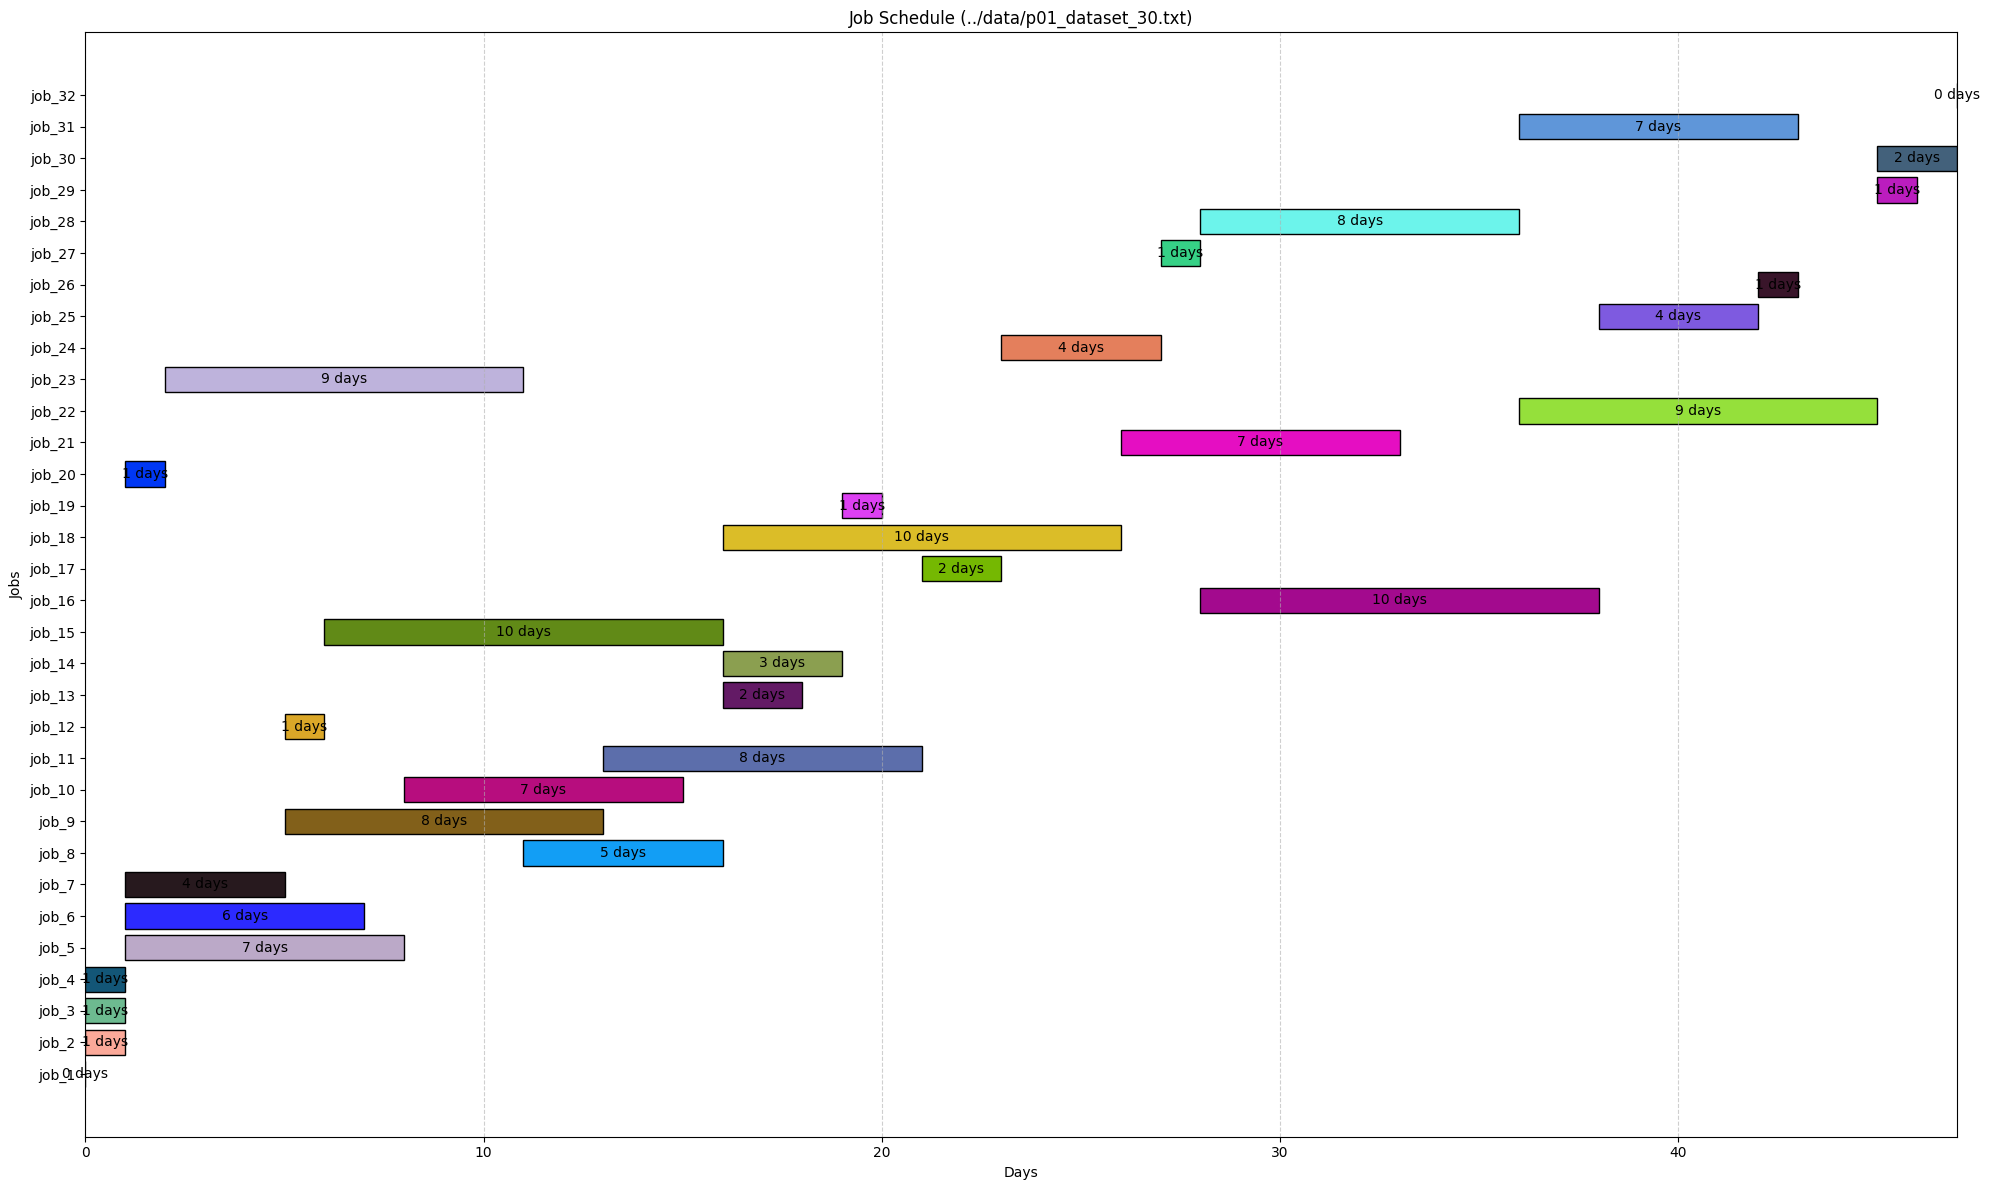

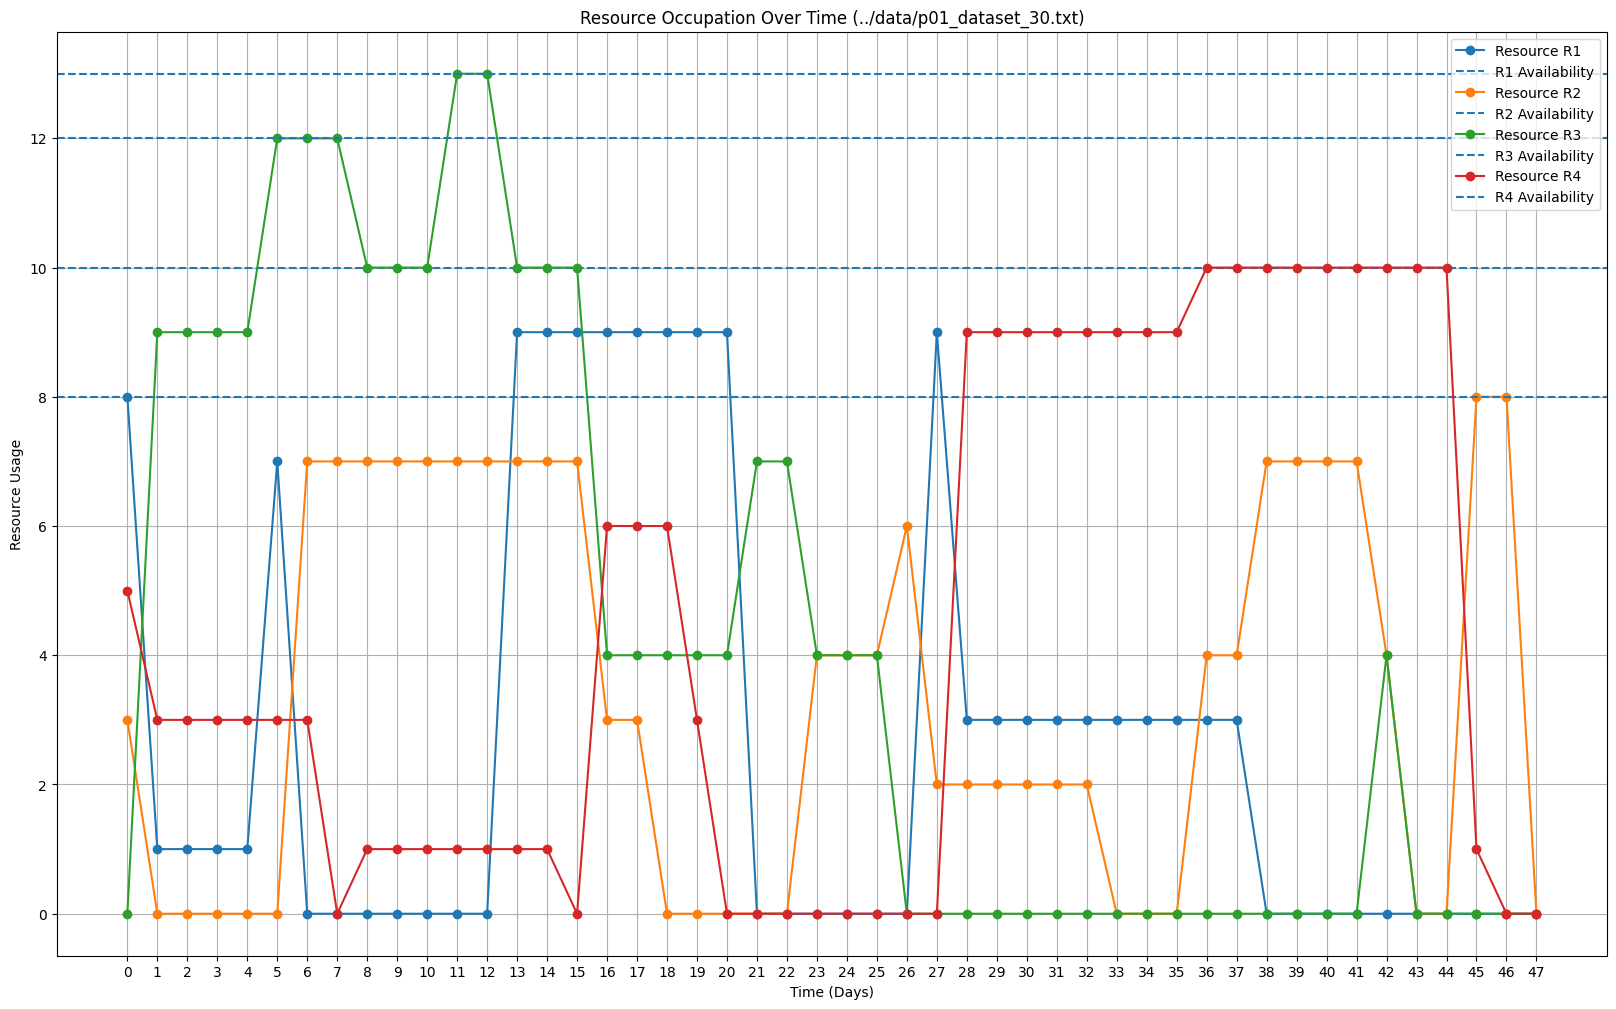

INFO:root: Drawing time: 0.6376 seconds
INFO:root: Execution time: 0.6540 seconds


In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

start_time = time()

# # # # # # # # # # # # # # # # # # # # # # # # # # #
# Modify this path to the correct dataSet location  #
# # # # # # # # # # # # # # # # # # # # # # # # # # #
file_path :str = "../data/p01_dataset_30.txt"

with open(file_path, "r") as file:
		proj_data: ProjectData = parse_file(file)
		
		model, start_times = define_problem(proj_data)
		solver = cp_model.CpSolver()

		status = solver.Solve(model)
		if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
				solution = extract_solution(solver, start_times, proj_data)

		get_solution_time = time()
		logging.info(
				f" Solution found : {(get_solution_time - start_time):.4f} seconds"
		)

		if solution:
			logging.info( f" Sollution: {solution}" )

			draw_solution(solution, proj_data, file_path)
			plot_resource_usage(solution, proj_data, file_path)
			
			logging.info(
				f" Drawing time: {(time() - get_solution_time):.4f} seconds"
			)


end_time = time()
logging.info(f" Execution time: {(end_time - start_time):.4f} seconds")
